# Yet Another OpenPose 

---
## Environment

In [2]:
#verify user
!whoami
#which Environment/virtualenv running in
import sys
import os

print("Python running from:",sys.prefix)
print("Current working dir",os.getcwd())

conex
Python running from: /home/conex/anaconda3/envs/train2
Current working dir /home/conex/Yet-Another-Openpose-Implementation/training


In [3]:
#start tensor board
# must run 
#/usr/local/bin/tensorboard serve --logdir gs://dl_training_results/tensorboard --port 8889 --bind_all
%load_ext tensorboard
%tensorboard --logdir=run/model10Wed0321-1433

/bin/bash: gcloud: command not found


---
## Config

In [4]:
!export PYTHONPATH=/home/conex/Yet-Another-Openpose-Implementation/:$PYTHONPATH
import sys
sys.path.append("..")

from configs import default_config as cfg

#import local_storage_config as storage_cfg
from configs import local_storage_config as storage_cfg
cfg.__dict__.update(storage_cfg.__dict__)

cfg.RUN_NAME="model" #for reference 

In [5]:
from utils import now
nowt=now()

import tensorflow as tf
print("Tensorflow version:",tf.version.VERSION)

Tensorflow version: 2.1.0


In [6]:
import datetime
import numpy as np

import dataset_functions
import models.six_stage_linear_model as model
import callbacks
import dataset_builder
import load_weights
import loss_metrics

In [9]:
# import importlib as il
# il.reload() #useful to reload any changes

---
## Dataset

In [9]:
# Training settings
TRAINING_EPOCHS = 30
REAL_EPOCH_STEPS = int(cfg.DATASET_SIZE / cfg.BATCH_SIZE)
SHORT_EPOCH_STEPS=50 #actual epocsh used in training, smaller than real epoch, but allows to track progress better, [in batches]
SHORT_TRAINING_EPOCHS=int(TRAINING_EPOCHS*(REAL_EPOCH_STEPS/SHORT_EPOCH_STEPS))
SHORT_VALIDATION_STEPS=5 #per short epoch

EPOCH_RATIO=int(REAL_EPOCH_STEPS / SHORT_EPOCH_STEPS)
# adam_learning_rate=0.001  #for reference
BASE_LEARNING_RATE = 0.0001
LEARNING_RATE_SCHEDUELE = np.zeros(100000)  #used with short epochs
LEARNING_RATE_SCHEDUELE[:3 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[3 * EPOCH_RATIO:20 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[20 * EPOCH_RATIO:40 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[40 * EPOCH_RATIO:100 * EPOCH_RATIO] = 0.5
LEARNING_RATE_SCHEDUELE[100 * EPOCH_RATIO:] = 0.3
LEARNING_RATE_SCHEDUELE *= BASE_LEARNING_RATE

In [10]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: /home/conex/Yet-Another-Openpose-Implementation/mydata/training
Retrieving TFrecords from: /home/conex/Yet-Another-Openpose-Implementation/mydata/validation
Found the following training TFrecords:
 /home/conex/Yet-Another-Openpose-Implementation/mydata/training-001.tfrecords
/home/conex/Yet-Another-Openpose-Implementation/mydata/training-002.tfrecords
/home/conex/Yet-Another-Openpose-Implementation/mydata/training-003.tfrecords
Found the following validation TFrecords:
 /home/conex/Yet-Another-Openpose-Implementation/mydata/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDatas

In [11]:
#Test element
dst_iter=iter(dst)
sample_elem=next(dst_iter)
print("Dataset shape:",dst) #this should match the model input, and output stages

Dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


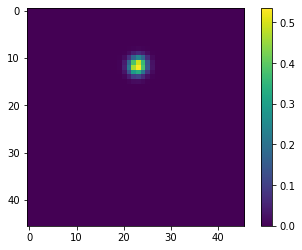

In [14]:
#testing mask
sample_elem=next(dst_iter)
m=sample_elem[1][1][0,...,0]
import matplotlib.pyplot as plt
plt.imshow(m)
plt.colorbar()

---
## Model
### Load weights

In [15]:
if cfg.ASK_FOR_CHECKPOINTS:
    checkpoint,starting_epoch=load_weights.checkpoints_prompt(cfg)
else:
    checkpoint=None
    starting_epoch=0

Found no checkpoints


### Build Model

In [16]:
model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model
def define():
    train_model,test_model=model_maker.create_models()
    
#     if cfg.INCLUDE_MASK:
#         losses=[loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanAbsoluteError()
#                 ,loss_metrics.MaskedMeanSquaredError()
#                 ,loss_metrics.MaskedMeanSquaredError()]                      
#     else:
#         raise NotImplementedError       
    
    #this must match the model output order
    metrics=[
              [loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]    
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
        ]
    
    train_model.compile(
                    optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                    ,loss=loss_metrics.MaskedMeanSquaredError()
                    ,loss_weights=[5,5,5,5,1,1]
                    ,metrics=metrics                           
                   )
    print('done')
    return train_model,test_model

if cfg.TPU_MODE:
    with strategy.scope():
        train_model,test_model=define()
        if (checkpoint):
            train_model.load_weights(checkpoint)
else:
    train_model,test_model=define()
    if (checkpoint):
        print('checkpoint')
        train_model.load_weights(checkpoint)

done


### Callbacks

In [17]:
from os import makedirs
from training import utils

freq = REAL_EPOCH_STEPS*cfg.BATCH_SIZE
checkpoints_path = cfg.CHECKPOINTS_PATH + "/" + cfg.RUN_NAME + nowt + "/-E{epoch}.ckpt"
print(checkpoints_path)
makedirs(cfg.CHECKPOINTS_PATH + "/" + cfg.RUN_NAME + utils.now(), exist_ok=True)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=freq)

/home/conex/Yet-Another-Openpose-Implementation/trained/checkpoints/model31Wed0321-1543/-E{epoch}.ckpt


In [18]:
#run to clean all tensorboard&checkpoints results
!gsutil -m rm -r {cfg.TENSORBOARD_PATH}/*
!gsutil -m rm -r {cfg.CHECKPOINTS_PATH}/*

/bin/bash: gsutil: command not found
/bin/bash: gsutil: command not found


---
## Training
Actually training

In [19]:
train_history=train_model.fit(
    dst
    ,epochs=SHORT_TRAINING_EPOCHS
    ,steps_per_epoch=SHORT_EPOCH_STEPS
    ,validation_steps=SHORT_VALIDATION_STEPS
    ,validation_data=dsv
    ,callbacks=[tensorboard_callback]
    ,initial_epoch=starting_epoch
)

Train for 50 steps, validate for 5 steps
Epoch 1/600
 1/50 [..............................] - ETA: 4:07

KeyboardInterrupt: 

In [ ]:
#run to clear this run results
#!gsutil -m rm -r {tensorboard_path}/*
#!gsutil -m rm -r {checkpoint_path}/*

---
### Save results

In [24]:
tmp_path='./temp_weights'
train_model.save_weights(tmp_path)

local_model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

cpu_train_model,cpu_test_model=local_model_maker.create_models()

cpu_train_model.load_weights(tmp_path)
cpu_test_model.load_weights(tmp_path)

cpu_test_model.save(cfg.MODELS_PATH+"/test_"+cfg.RUN_NAME+nowt,include_optimizer=False) 
cpu_train_model.save(cfg.MODELS_PATH+"/train_"+cfg.RUN_NAME+nowt,include_optimizer=False) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/conex/Yet-Another-Openpose-Implementation/trained/models/test_model10Wed0321-1433/assets
INFO:tensorflow:Assets written to: /home/conex/Yet-Another-Openpose-Implementation/trained/models/train_model10Wed0321-1433/assets


---
### Shutdown

In [21]:
#shut down TPU
!gcloud compute tpus stop node-1 --zone us-central1-c

Request issued for: [node-1]
Waiting for operation [projects/deeplearning-257902/locations/us-central1-c/ope
rations/operation-1576394557945-599b8f5a6f715-cea18a91-dac3461a] to complete...
done.                                                                          
done: true
metadata:
  '@type': type.googleapis.com/google.cloud.common.OperationMetadata
  apiVersion: v1
  cancelRequested: false
  createTime: '2019-12-15T07:22:37.986277963Z'
  endTime: '2019-12-15T07:24:02.963746255Z'
  target: projects/deeplearning-257902/locations/us-central1-c/nodes/node-1
  verb: update
name: projects/deeplearning-257902/locations/us-central1-c/operations/operation-1576394557945-599b8f5a6f715-cea18a91-dac3461a
response:
  '@type': type.googleapis.com/google.cloud.tpu.v1.Node
  acceleratorType: v2-8
  cidrBlock: 10.0.3.0/29
  createTime: '2019-11-26T18:14:01.401101656Z'
  health: HEALTHY
  ipAddress: 10.0.3.2
  name: projects/deeplearning-257902/locations/us-central1-c/nodes/node-1
  network: glob

In [ ]:
#shut down this host
!gcloud compute instances stop instance-1 --zone us-central1-c

Stopping instance(s) instance-1...⠹                                            